<a href="https://colab.research.google.com/github/moebarati/CLS_Final_Project/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing the required dependencies for "distilbert-base-uncased-emotion" and "text2emotion"
!pip install transformers
!pip install text2emotion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the necessary modules & packages

import pandas as pd

import re
import os
from os import listdir
import tarfile
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import pipeline
import text2emotion as te

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
potter = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/CLS/tales/Potter.tar.gz'
anderson = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/CLS/tales/HCAndersen.tar.gz'
grimms = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/CLS/tales/Grimms.tar.gz'

output_folder = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/CLS/tales/ExtractedFiles'

In [ ]:
def open_tar_file(file_path):
  tf = tarfile.open(file_path, 'r')
  tf.extractall(path = output_folder)
  return

In [ ]:
open_tar_file(potter)

In [ ]:
open_tar_file(anderson)

In [ ]:
open_tar_file(grimms)

In [ ]:
folders = ['Potter', 'HCAndersen', 'Grimms']
data = {}

for folder in folders:
  focus_folder = str(output_folder) + '/' + str(folder) + '/' + 'agree-sent'
  for f in listdir(focus_folder):
    path = str(focus_folder) + '/' + str(f)
    file = open(path, 'r')
    lines = file.readlines()
    for line in lines:
      emotion = re.split('@', line, maxsplit = 3)[1]
      sent = re.split('@', line, maxsplit = 3)[2]
      sent = re.sub("\n", "", sent)
      data[sent] = emotion

df = pd.DataFrame.from_dict(data, orient = 'index')
df = df.reset_index()
df.columns =['sentence', 'emotion']
df.head()

,sentence,emotion
0,It feels sad.,6
1,"The tailor replied: ""Simpkin, we shall make ou...",6
2,"Then the tailor started; for suddenly, interru...",7
3,"""This is passing extraordinary!"" said the Tail...",7
4,But Simpkin hid a little parcel privately in t...,2


In [ ]:
len(df)

1205

In [ ]:
df['emotion'].value_counts()

4    444
6    264
2    217
3    166
7    114
Name: emotion, dtype: int64

In [ ]:
bert_classifier = pipeline("text-classification", model = 'bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores = False)
xlm_classifier = pipeline("text-classification", model = 'MilaNLProc/xlm-emo-t', return_all_scores = False)

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:
emotion_map = {
    '2': ['angry', 'anger'],
    '3': ['fear'],
    '4': ['happy', 'joy', 'love'],
    '6': ['sad', 'sadness'],
    '7': ['surprise']
    }

In [ ]:
def get_emotion(word):
  for key, val in emotion_map.items():
    if word in val:
      return key

def text_emotion(segment):
  emotion = te.get_emotion(segment)
  max_emo = max(emotion, key = emotion.get)
  max_emo = get_emotion(max_emo.lower())
  return max_emo

def bert_emotion(segment):
  emotion = bert_classifier(segment)
  bert_emo = emotion[0]['label']
  bert_emo = get_emotion(bert_emo)
  return bert_emo

def xlm_emotion(segment):
  emotion = xlm_classifier(segment)
  xlm_emo = emotion[0]['label']
  xlm_emo = get_emotion(xlm_emo)
  return xlm_emo

In [ ]:
df['bert'], df['t2e'], df['xlm'] = "", "", ""

for idx, row in df.iterrows():
  sent = row['sentence']
  df.at[idx, 'bert'] = bert_emotion(sent)
  df.at[idx, 't2e'] = text_emotion(sent)
  df.at[idx, 'xlm'] = xlm_emotion(sent)

In [ ]:
df.head()

,sentence,emotion,bert,t2e,xlm
0,It feels sad.,6,6,6,6
1,"The tailor replied: ""Simpkin, we shall make ou...",6,4,4,3
2,"Then the tailor started; for suddenly, interru...",7,2,7,3
3,"""This is passing extraordinary!"" said the Tail...",7,4,7,4
4,But Simpkin hid a little parcel privately in t...,2,2,2,4


Accuracy: 66.3070539419087%
              precision    recall  f1-score   support

           2       0.48      0.73      0.58       217
           3       0.63      0.57      0.60       166
           4       0.76      0.85      0.80       444
           6       0.72      0.57      0.64       264
           7       0.89      0.15      0.26       114

    accuracy                           0.66      1205
   macro avg       0.70      0.58      0.58      1205
weighted avg       0.70      0.66      0.65      1205

Confusion Matrix for distilbert-base-uncased-emotion: 
[[159   5  28  25   0]
 [ 39  95  14  18   0]
 [ 42  10 377  13   2]
 [ 50  19  44 151   0]
 [ 39  22  32   4  17]]


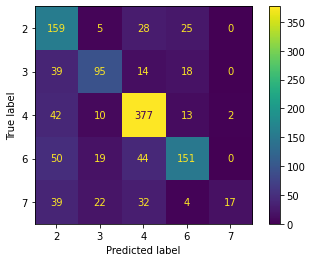

In [ ]:
name = 'distilbert-base-uncased-emotion'
y_pred = df['bert']
y_test = df['emotion']
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for ' + name + ': \n' + str(cm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plot = plt.show()

Accuracy: 38.755186721991706%
              precision    recall  f1-score   support

           2       0.44      0.21      0.29       217
           3       0.27      0.34      0.30       166
           4       0.66      0.47      0.55       444
           6       0.41      0.36      0.38       264
           7       0.18      0.54      0.27       114

    accuracy                           0.39      1205
   macro avg       0.39      0.38      0.36      1205
weighted avg       0.46      0.39      0.40      1205

Confusion Matrix for text2emotion: 
[[ 46  30  39  35  67]
 [ 13  57  14  30  52]
 [ 16  71 208  65  84]
 [ 23  40  35  94  72]
 [  7  17  20   8  62]]


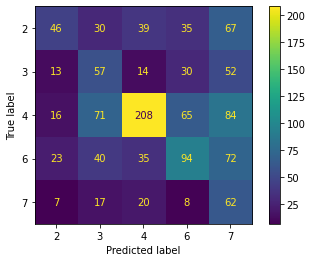

In [ ]:
name = 'text2emotion'
y_pred = df['t2e']
y_test = df['emotion']
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for ' + name + ': \n' + str(cm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plot = plt.show()

Accuracy: 71.53526970954357%
              precision    recall  f1-score   support

           2       0.88      0.55      0.68       217
           3       0.68      0.66      0.67       166
           4       0.73      0.96      0.83       444
           6       0.64      0.77      0.70       264
           7       0.00      0.00      0.00       114

    accuracy                           0.72      1205
   macro avg       0.59      0.59      0.58      1205
weighted avg       0.66      0.72      0.67      1205

Confusion Matrix for XLM-EMO: 
[[120  11  36  50   0]
 [  3 110  20  33   0]
 [  1   5 428  10   0]
 [  3  13  44 204   0]
 [  9  22  61  22   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


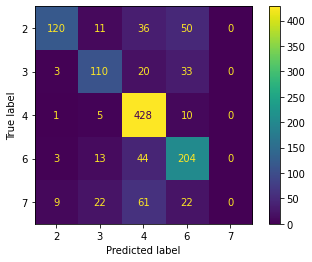

In [ ]:
name = 'XLM-EMO'
y_pred = df['xlm']
y_test = df['emotion']
print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for ' + name + ': \n' + str(cm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plot = plt.show()